In [ ]:
"""
    This is a supervised problem with labeled training examples
    It is a multiple regression task because it's taking in multiple values
    It is a univariate regression problem because it's only predicting one value, median housing price
    Small dataset, so this can be a simple batch learning job
    Using RMSE as the performance metric
"""


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
housing = pd.read_csv('./housing.csv')

## EDA

In [ ]:

#housing.head()
#housing.info()
#housing.describe()
housing['ocean_proximity'].value_counts()

In [ ]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

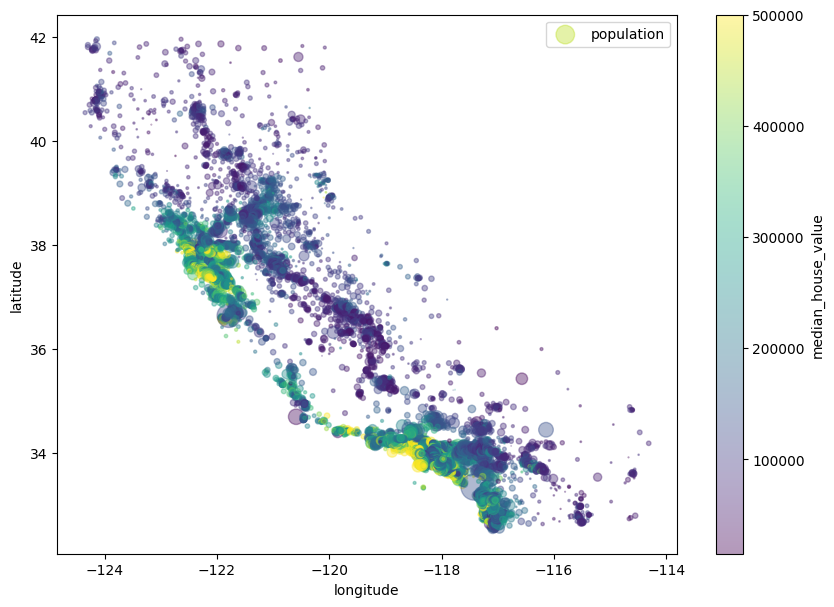

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", colorbar=True,
)
plt.legend()

#showing the map of californeia

C:\Users\micha\AppData\Local\Temp\ipykernel_6244\1671603143.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr() #helps determine linear correlations in smaller datasets


<AxesSubplot: xlabel='median_income', ylabel='median_house_value'>

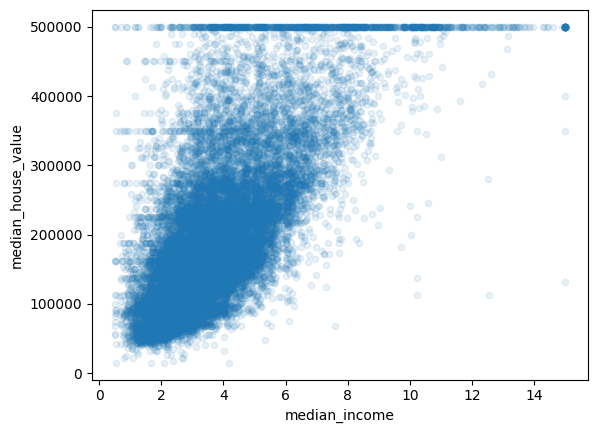

In [36]:
corr_matrix = housing.corr() #helps determine linear correlations in smaller datasets
corr_matrix['median_house_value'].sort_values(ascending=False)

from pandas.plotting import scatter_matrix
#scatter_matrix(housing[['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']], figsize=(12,8))
#this shows a rough correlation between median house value and median income; investigaet futehr
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=.1)


## Feature Engineering

In [38]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3,6.281853,0.172096,2.181467


## Creating a Test Set

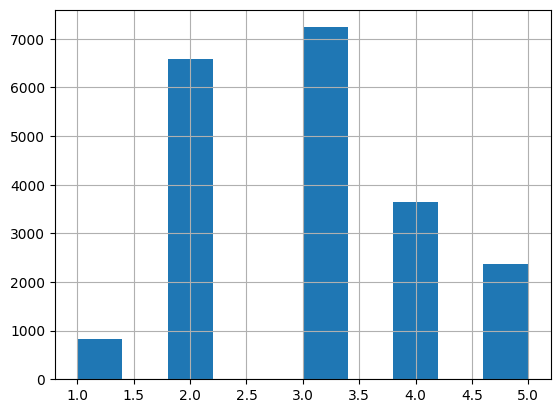

In [18]:
#homemade function
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))    
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
# this does the job, but it's weakness is that it returns a different test and train set every time you run it
# it needs to set one train & test set, and stick with it; especially when you get new data in the dataset

# 2 actual implementations
from sklearn.model_selection import train_test_split

train_set, test_set = train_set, test_set = train_test_split(housing, test_size=.2, random_state=42)
#this is good but because its done randomly, it could introduce sampling bias & uneqal representaion

#stratified sampling - done as an example on the median income field

#coverting the median income field into a categorical field so it can be used with stratified sampling
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing['income_cat'].hist()

#the actual stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#testing the stratification
strat_test_set['income_cat'].value_counts() / len(strat_test_set) 
#this shows the proportion of each category reflects the overall population proportions better than random sampleing

#removing the income_cat field to return the dataset back to its orignal state
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## Data Cleaning

In [56]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

#takes care of null values in one column
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

#takes care of null values in all numerical columns
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='median')
# housing_num = housing.drop('ocean_proximity', axis=1)
# imputer.fit(housing_num)
# imputer.statistics_ #array of medians for each feature/column

# X = imputer.transform(housing_num)
# housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

#handling categorical data with ordinal encoding
housing_cat = housing[['ocean_proximity']]

# from sklearn.preprocessing import OrdinalEncoder
# ordinal_encoder = OrdinalEncoder()
# housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
# ordinal_encoder.categories_

#handling categorical data with onehotencoding
"""from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()
cat_encoder.categories_
"""



from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformation Pipeline and Feature Scaling

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [61]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])


housing_prepared = pd.DataFrame(full_pipeline.fit_transform(housing))

In [62]:
housing_prepared.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.017395,0.006223,-0.121122,0.0,1.0,0.0,0.0,0.0
1,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.569256,-0.040811,-0.810867,0.0,0.0,0.0,0.0,1.0
2,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,-0.018024,-0.075371,-0.338273,0.0,1.0,0.0,0.0,0.0
3,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,-0.595140,-0.106803,0.961205,0.0,0.0,0.0,0.0,1.0
4,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,0.251241,0.006109,-0.474513,1.0,0.0,0.0,0.0,0.0


## Model Training

In [63]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
linrmse = np.sqrt(lin_mse)
linrmse #rmse of 68634 not very good, probably underfitting

68634.19939446161

In [64]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [70]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
#tree_rmse_scores

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
lin_rmse_scores

array([71777.6526835 , 64114.99166359, 67771.17124356, 68613.53563082,
       66830.07826384, 72549.78052544, 73997.08050233, 68830.96225316,
       66443.28836884, 70144.72439169])

In [74]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

rf_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-rf_scores)
rf_rmse_scores

array([51292.70683781, 49081.32003514, 47206.60651903, 51934.51478414,
       47399.92038578, 51764.58185732, 52425.47582043, 49915.50462712,
       48506.81915062, 54157.00760784])

## Fine Tuning Model

In [ ]:
#test
print('test')